# Cross Stitch Patterns from Images

**Author:** [J.L. Klay](jlklay@gmail.com)

**Update:** 10-July-2019 converted code to Python3.7

This code will create a counted cross-stitch pattern from an image by pixellating it, determining color maps and replacing each pixel by a symbol on a pattern grid for each color.  One can choose how many different colors to allow for a given image so that it is possible to minimize the complexity.  The pattern is output to a file called `Pattern.pdf`.

## Example Usage

Here is an example of how the code is used to create the pattern, showing the steps of the process, with helpful display output.  To create your own pattern, just modify the list of inputs and execute the remaining code cells.  The default pattern created here is from a Higgs Boson Event image on wikipedia.  The pattern can be created at the bottom of this notebook with one call to the `testme` function provided with the code library.

In [1]:
#Preliminaries
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Import the StitchIt library
import StitchIt as st

## Define the pattern inputs

In [3]:
#Define the inputs
imgurl = "http://upload.wikimedia.org/wikipedia/commons/1/1c/CMS_Higgs-event.jpg" #image file to pattern
pattern_name = "Higgs Boson Event" #Name for pattern
aidacolor = "black" #cloth color
aidasize = 14 #number of stitches per inch of aida cloth
reduct = 25 #Reduce the image size to this percent of the original
numcol = 24 #number of colors to reduce image to

## Retrieve the image file

Pixel dimensions: (1104 x 1018)
Aida Cloth count: 14
Pattern dimensions: (78.86 in x 72.71 in)
Pattern colors: 237118


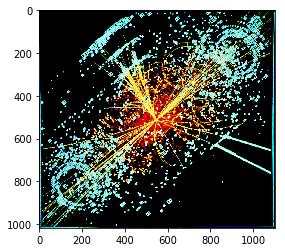

In [4]:
#Retrieve image file
response = requests.get(imgurl)
before = plt.imread(BytesIO(response.content),format="jpg")
plt.imshow(before);
x,y = st.aida_size(before,aidasize,verbosity=1)

## Reduce the image size

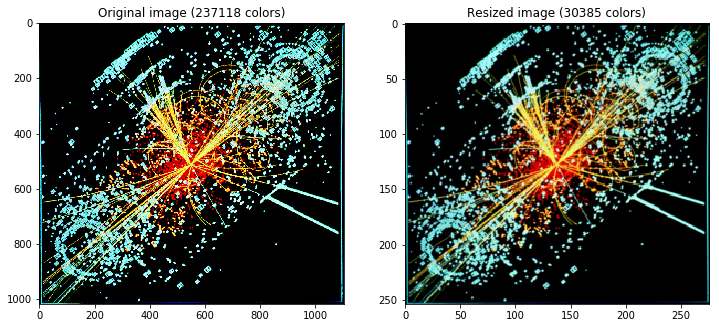

Pixel dimensions: (276 x 254)
Aida Cloth count: 14
Pattern dimensions: (19.71 in x 18.14 in)
Pattern colors: 30385


In [5]:
#Reduce the size of the image
smaller = st.resize(before,reduct)
st.plot_before_after(before,smaller,"Resized")
x,y = st.aida_size(smaller,aidasize,verbosity=1)

## Reduce the number of image colors

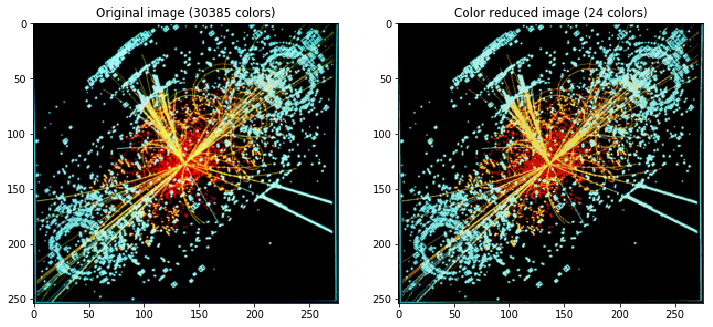

Pixel dimensions: (276 x 254)
Aida Cloth count: 14
Pattern dimensions: (19.71 in x 18.14 in)
Pattern colors: 24


In [8]:
#Reduce the number of colors in the image
colors, counts, after = st.reduce_colors(smaller, numcol)
st.plot_before_after(smaller,after,"Color reduced")
x,y = st.aida_size(after,aidasize,verbosity=1)

## Match DMC floss colors and replace them in image

Counts	RGBColor	Floss#	FlossRGB	#Skeins	FlossName
125126 	 [0 0 0] 	 310 	 [0 0 0] 	 55.11 	 ['Black' '000000']
13318 	 [173 175 114] 	 471 	 [174 191 121] 	 5.87 	 ['Avocado Grn V Lt ' 'AEBF79']
9518 	 [142 203 189] 	 993 	 [144 192 180] 	 4.19 	 ['Aquamarine Vy Lt ' '90C0B4']
8452 	 [138  78  24] 	 975 	 [145  79  18] 	 3.72 	 ['Golden Brown Dk ' '914F12']
6082 	 [232 218  86] 	 726 	 [253 215  85] 	 2.68 	 ['Topaz Light ' 'FDD755']
5730 	 [203  17   6] 	 817 	 [187   5  31] 	 2.52 	 ['Coral Red Very Dark' 'BB051F']
5000 	 [ 99 105  53] 	 937 	 [ 98 113  51] 	 2.20 	 ['Avocado Green Md ' '627133']
4576 	 [ 9 18 18] 	 3371 	 [30 17  8] 	 2.02 	 ['Black Brown ' '1E1108']
3277 	 [213  97  27] 	 921 	 [198  98  24] 	 1.44 	 ['Copper ' 'C66218']
3263 	 [180 237 226] 	 3811 	 [188 227 230] 	 1.44 	 ['Turquoise Very Light ' 'BCE3E6']
3106 	 [120  11   5] 	 814 	 [123   0  27] 	 1.37 	 ['Garnet Dark' '7B001B']
3047 	 [45 19  7] 	 3371 	 [30 17  8] 	 1.34 	 ['Black Brown ' '1E1108']
2392 	 [1

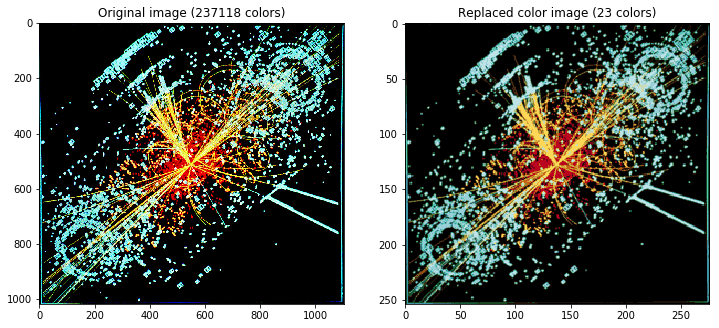

Pixel dimensions: (276 x 254)
Aida Cloth count: 14
Pattern dimensions: (19.71 in x 18.14 in)
Pattern colors: 23


In [9]:
#Find the best-matched floss colors for the colors in the reduced image
summary = st.floss_color_counts(colors,counts,aidasize,verbosity=1)
#Replace colors in the image with matched floss colors one at a time
print("\nReplacing colors in image:")
for (skeins, floss, name, oldcolor, matchedcolor) in summary:
    st.replace_color(after,oldcolor,matchedcolor,verbosity=1)

st.plot_before_after(before,after,"Replaced color")
x,y = st.aida_size(after,aidasize,verbosity=1)

## Is it a good match?

If the color matched image is not to your liking, you can inspect the available floss colors and replace any/all of them with other colors using the `replace_color` function.  The other option is to re-run the color reduction cell to get a different set of reduced colors.

In [ ]:
#Show the DMC color matches
st.view_colors(summary)

## Create the final pattern

Assuming you are happy with the way the image looks, you can now create the final pattern from the transformed image.

In [10]:
#Create the final pattern
print("Creating your pattern in a file called Pattern.pdf.  Enjoy!")
st.make_pattern(before,after,aidasize,imgurl,pattern_name,aidacolor)

Creating your pattern in a file called Pattern.pdf.  Enjoy!
Adding Cover page
Adding page 0
Adding page 1
Adding page 2
Adding page 3
Adding page 4
Adding page 5
Adding page 6
Adding page 7
Adding page 8
Adding page 9
Adding page 10
Adding page 11
Adding page 12
All DONE!


---

# Create the default Higgs Boson pattern with one function call

If you don't want to go through all the steps yourself, or you've modified the code to make a pattern from your own image, you can still get the Higgs Boson pattern by executing the following cell.

In [ ]:
#Call the testme function to do it all!
st.testme(1)

---